<a href="https://colab.research.google.com/github/alitootoonchian/FinTech/blob/master/StockPredTF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime as dt
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas_datareader.data  as pdr
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [12, 6]


In [0]:
training_days = 20
total_years = 20
total_dates = total_years * 365
training_itmes = (int)(total_years * 252 * 0.7)

In [0]:
ticker = 'IBM' #@param ["GOOG", "IBM", "MSFT", "AAPL"]
predict_days = "4" #@param [1, 2, 3, 4, 7]
start_date = '2019-01-01' #@param {type:"date"}
end_date = '2020-01-01' #@param {type:"date"}
n_days = int(predict_days)
data = pdr.get_data_yahoo(ticker, dt.date.today() - dt.timedelta(total_dates), dt.date.today())
data = data.dropna()
data = data[['High', 'Low', 'Open', 'Close']]

In [0]:
def normalize_data(df):
  features = ['Open', 'High', 'Low', 'Close']
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  for feature in features:
    df[feature] = min_max_scaler.fit_transform(df[feature].values.reshape(-1, 1))
  return df, min_max_scaler

In [0]:
data, scaler = normalize_data(data)

In [7]:
valid_set_size_percentage = 10
test_set_size_percentage = 10
seq_len = 20

def load_data(stock, seq_len):
  data_raw = stock.values
  data = []
  for index in range(len(data_raw) - seq_len):
    data.append(data_raw[index: index + seq_len])
  data = np.array(data)
  valid_set_size = int(valid_set_size_percentage/100*data.shape[0])
  test_set_size = int(test_set_size_percentage/100*data.shape[0])
  train_set_size = len(data) - valid_set_size - test_set_size
  x_train = data[:train_set_size,:-1,:]
  y_train = data[:train_set_size, -1,:]
  x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
  y_valid = data[train_set_size:train_set_size+valid_set_size, -1,:]
  x_test  = data[train_set_size+valid_set_size:,:-1,:]
  y_test  = data[train_set_size+valid_set_size:, -1,:]
  return [x_train, y_train, x_valid, y_valid, x_test, y_test]

x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(data, seq_len)
print ('x_train.shape:', x_train.shape)
print ('y_train.shape:', y_train.shape)
print ('x_valid.shape:', x_valid.shape)
print ('y_valid.shape:', y_valid.shape)
print (' x_test.shape:', x_test.shape)
print (' y_test.shape:', y_test.shape)

x_train.shape: (4007, 19, 4)
y_train.shape: (4007, 4)
x_valid.shape: (500, 19, 4)
y_valid.shape: (500, 4)
 x_test.shape: (500, 19, 4)
 y_test.shape: (500, 4)


In [0]:
n_steps = seq_len - 1
n_inputs = 4
n_neurons = 200
n_outputs = 4
n_layers = 2
learining_rate = 0.001
batch_size = 50
n_epoch = 100
train_set_size = x_test.shape[0]
test_set_size = x_test.shape[0]
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

In [0]:
index_in_epoch = 0
perm_array = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

def get_next_batch(batch_size):
  global index_in_epoch, x_train, perm_array
  start = index_in_epoch
  index_in_epoch += batch_size
  if index_in_epoch > x_train.shape[0]:
    np.random.shuffle(perm_array)
    start = 0
    index_in_epoch += batch_size
  end = index_in_epoch
  return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

In [10]:
#RNN
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu) for layer in range(n_layers)]

#LTSM
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.relu) for layer in range(n_layers)]

#LTSM with us peepholes
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, activation=tf.nn.leaky_relu, use_peepholes=True) for layer in range(n_layers)]

# GRU
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu) for layer in range(n_layers)]

multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:]

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for upd

In [0]:
loss = tf.reduce_mean(tf.square(outputs - y))

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=learining_rate)
training_op = optimizer.minimize(loss)

In [13]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for iteration in range(int(n_epoch*train_set_size/batch_size)):
    x_batch, y_batch = get_next_batch(batch_size)
    sess.run(training_op, feed_dict={X: x_batch, y: y_batch})
    if iteration % int(5*train_set_size/batch_size) == 0:
      mse_train = loss.eval(feed_dict={X: x_train, y: y_train})
      mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid})
      print ('%.2f epochs: MSE train/valid = %.6f/%.6f'%(iteration*batch_size/train_set_size, mse_train, mse_valid))
  y_test_pred = sess.run(outputs, feed_dict={X: x_test})

0.00 epochs: MSE train/valid = 0.155338/0.243713
5.00 epochs: MSE train/valid = 0.000247/0.000224
10.00 epochs: MSE train/valid = 0.000186/0.000155
15.00 epochs: MSE train/valid = 0.000152/0.000133
20.00 epochs: MSE train/valid = 0.000122/0.000105
25.00 epochs: MSE train/valid = 0.000105/0.000092
30.00 epochs: MSE train/valid = 0.000113/0.000110
35.00 epochs: MSE train/valid = 0.000099/0.000087
40.00 epochs: MSE train/valid = 0.000098/0.000087
45.00 epochs: MSE train/valid = 0.000097/0.000086
50.00 epochs: MSE train/valid = 0.000099/0.000093
55.00 epochs: MSE train/valid = 0.000095/0.000086
60.00 epochs: MSE train/valid = 0.000095/0.000088
65.00 epochs: MSE train/valid = 0.000094/0.000086
70.00 epochs: MSE train/valid = 0.000094/0.000085
75.00 epochs: MSE train/valid = 0.000094/0.000085
80.00 epochs: MSE train/valid = 0.000091/0.000085
85.00 epochs: MSE train/valid = 0.000091/0.000085
90.00 epochs: MSE train/valid = 0.000092/0.000091
95.00 epochs: MSE train/valid = 0.000091/0.000086


In [14]:
y_test_pred.shape

(500, 4)

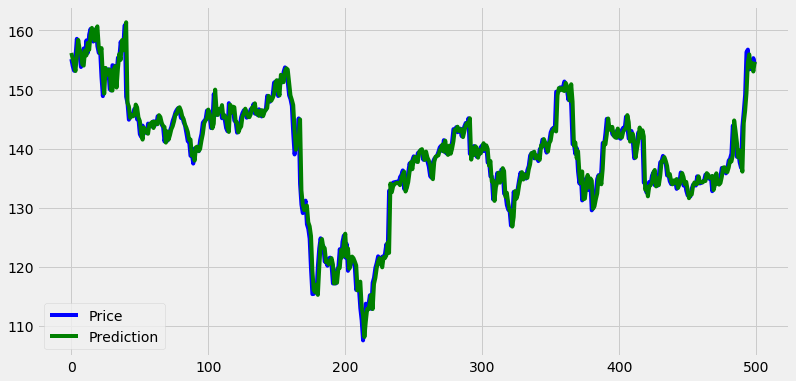

In [90]:
target_price = scaler.inverse_transform(y_test[:,3].reshape(-1,1))[:,0]
predict_price = scaler.inverse_transform(y_test_pred[:,3].reshape(-1,1))[:,0]
comp = pd.DataFrame({'price':target_price, 'pred':predict_price})
plt.plot(comp['price'], color = 'blue', label='Price')
plt.plot(comp['pred'], color = 'green', label='Prediction')
plt.legend()
plt.show()


In [114]:
n_day = 1  #@param {type: "slider", min: 1, max: 10}
next_price = comp.price.shift(-n_day)
next_pred = comp.pred.shift(-n_day)
price_change = comp.price - next_price
pred_change = comp.pred - next_pred
avg_ret = np.abs(((next_price - comp.price) / comp.price)).mean()
price_pred_change = (price_change * pred_change).apply(lambda x: 1 if x > 0 else 0)
success_prediction = price_pred_change.sum()/len(comp)
profit = 2 * success_prediction - 1
total_profit = (1 + profit) ** 7

print("      success = {:.3f}". format(success_prediction))
print("      avg ret = {:.3f}". format(avg_ret))
print("  daily profit = {:.3f}". format(profit))
print("  total profit = {:2.3f}". format(total_profit))


      success = 0.474
      avg ret = 0.010
  daily profit = -0.052
  total profit = 0.688


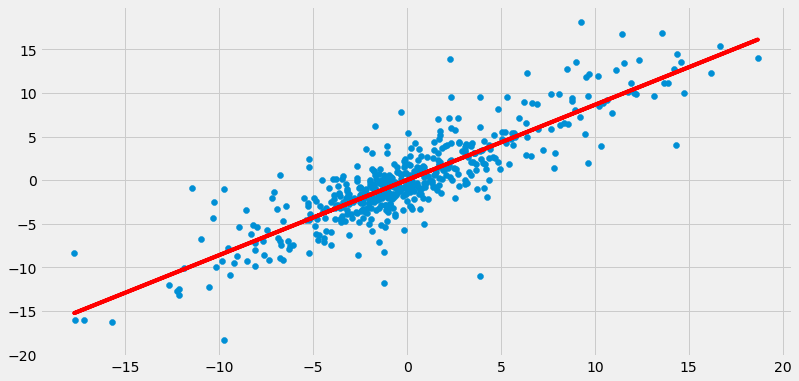

In [88]:
comp.dropna(inplace=True)
beta, alpha = np.polyfit(comp['NextPriceDiff'], comp['NextPrdictPriceDiff'], 1)
plt.scatter(x=comp['NextPriceDiff'], y=comp['NextPrdictPriceDiff'])
plt.plot(comp['NextPriceDiff'], comp['NextPriceDiff'] * beta + alpha, '-', c='r' )
plt.show()